In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
from matplotlib.lines import Line2D

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
datasets = [
    "dtd", 
    "flowers", 
    "fgvc_aircraft", 
    "sun397"
]
models = ['RN50', 'nllb-clip-base', 'ViT-B-32']

num_seeds = 4
out_path = "../output"
sample_sizes = {
    "dtd": [2, 4, 8, 16, 32, 46, 60], 
    "fgvc_aircraft": [2, 4, 8, 14, 20], 
    "sun397": [2, 4, 8, 16, 23, 30], 
    "flowers": [2, 4, 8, 14, 20],
}

model_names = {
    'RN50': 'ResNet50', 
    'nllb-clip-base': 'NLLB-CLIP', 
    'ViT-B-32': 'ViT-B/32'
}

data_names = {
    "dtd": 'Describable Textures', 
    "fgvc_aircraft": 'FGVC Aircraft', 
    "sun397": "SUN397", 
    "flowers": "Flowers 102",
}

color1 = "navy"
color5 = "tab:red"

In [4]:
def load_result(dataset, model, sample_size, seed):
    templates = f"{dataset}/sample_size_{sample_size:02d}_seed_{seed}"
    with open(os.path.join(out_path, f"{model}/{templates}.json"), 'r') as f:
        result = json.load(f)
    return result["metrics"]["acc1"], result["metrics"]["acc5"]

def load_baseline(dataset, model):
    with open(os.path.join(out_path, f"{model}/{dataset}/templates.json"), 'r') as f:
        result = json.load(f)
    return result["metrics"]["acc1"], result["metrics"]["acc5"]

def create_ax(ax, dataset, model, linewidth=3, zscore=1.96, capsize=4, s=5):
    ns = np.array(sample_sizes[dataset])
    acc1 = np.zeros(shape=(len(ns), num_seeds))
    acc5 = np.zeros(shape=(len(ns), num_seeds))
    for i, n in enumerate(ns):
        for j, seed in enumerate(range(num_seeds)):
            acc1[i, j], acc5[i, j] = load_result(dataset, model, n, seed)
    # for j, seed in enumerate(range(num_seeds)):
    #     ax.plot(ns, acc1[:, j], color=color1, alpha=0.5, linewidth=0.5)
    #     ax.plot(ns, acc5[:, j], color=color5, alpha=0.5, linewidth=0.5)

    # llm lines
    ax.errorbar(
        ns, 
        acc1.mean(axis=1), 
        yerr=zscore * acc1.std(axis=1), 
        color=color1, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=2 * s,
        label="Top-1 (CuPL)"
    )
    ax.errorbar(
        ns, 
        acc5.mean(axis=1), 
        yerr=zscore * acc5.std(axis=1), 
        color=color5, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt="s-",
        markersize=s,
        label="Top-5 (CuPL)"
    )
    acc1_base, acc5_base = load_baseline(dataset, model)
    ax.hlines(y=acc1_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color1, label="Top-1 (Templates)")
    ax.hlines(y=acc5_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color5, label="Top-5 (Templates)")

    # template lines



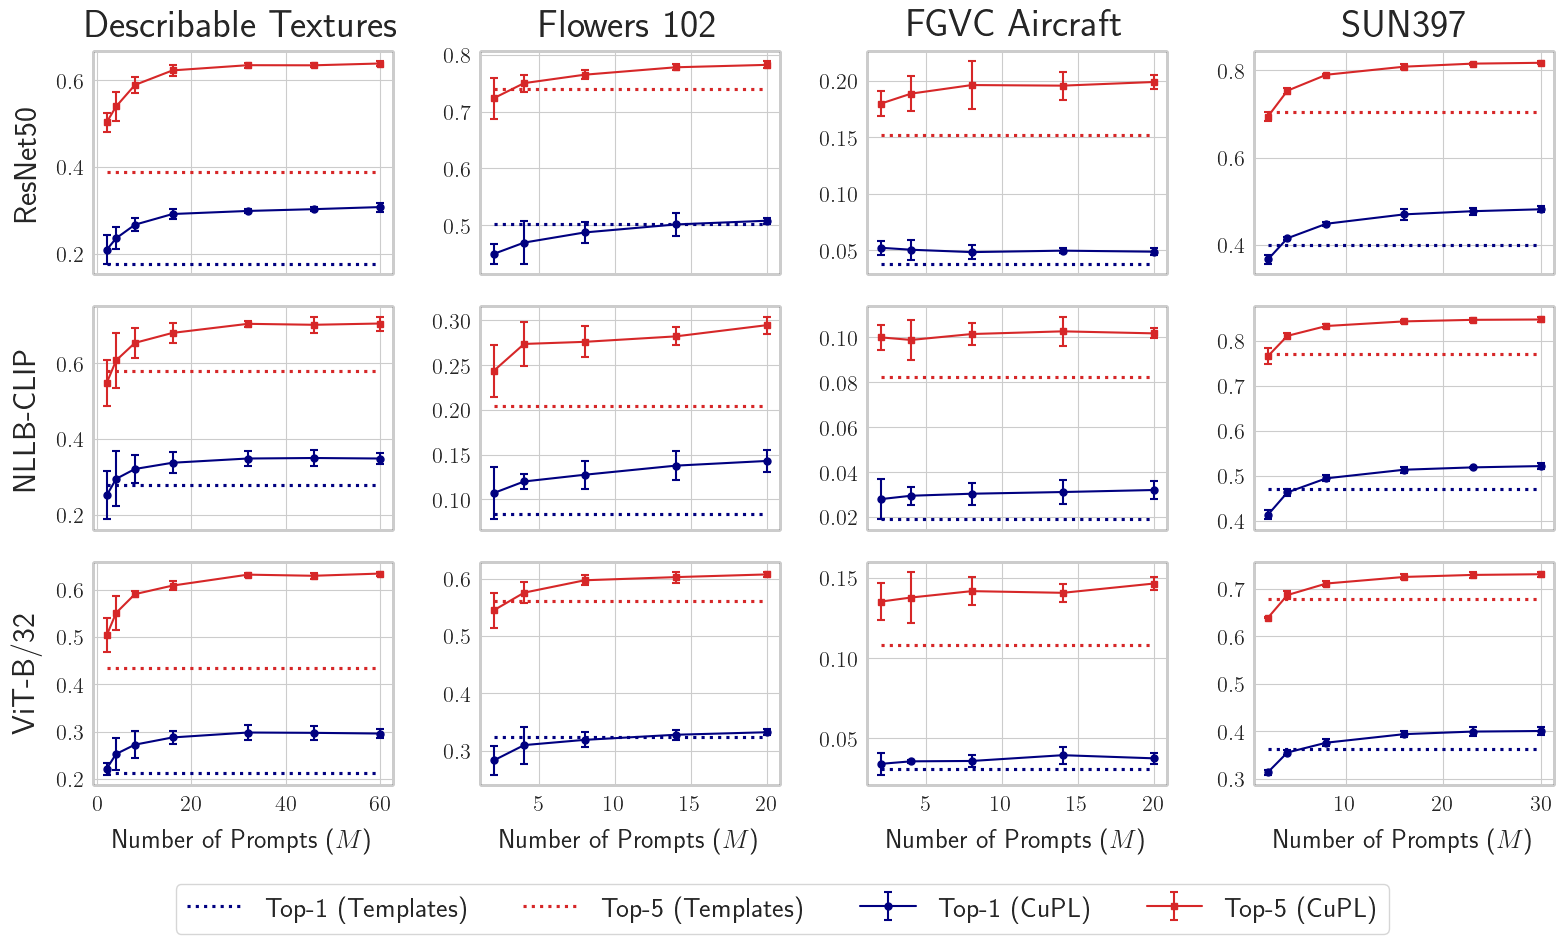

In [7]:
sns.set_style("whitegrid")

scale = 4
linewidth = 1.5
capsize = 3
fig, axes = plt.subplots(len(models), len(datasets), figsize=(scale * len(datasets), 0.75 * scale * len(models)), sharex="col")

for i, model in enumerate(models):
    axes[i, 0].set_ylabel(model_names[model], labelpad=10)
    for j, dataset in enumerate(datasets):
        axes[i, j].patch.set_edgecolor('black')  
        axes[i, j].patch.set_linewidth(1)  
        if i == 0:
            axes[i, j].set_title(data_names[dataset], y=1.03)
        if i == len(models) - 1:
            axes[i, j].set_xlabel(r"Number of Prompts ($M$)", labelpad=10, fontsize=19)
        create_ax(axes[i, j], dataset, model, linewidth=linewidth, capsize=capsize)



handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=4)

fig.tight_layout(pad=2.0)
plt.savefig("../figures/class_conditional_prompting.pdf", bbox_inches="tight")
plt.show()